<a href="https://colab.research.google.com/github/CobaMasa/RStan2PyStan/blob/20200422/chapter8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapeter8: Hierarchical model
**Tips**
- Some features (i.g)effects drived from Individuals or places) that are NOT OBSERVED in experiments, can be included within hierarchical models.
- These features are usually considered to be generated from $Normal(0, \sigma)$ and we can estimate the parameter $\sigma$from data.
- Even in the era of bigdata, or VUCA, sometime we can't collect enought data which stand for specific effects from individuals or groups, that's the time hierarchical models are good to be chosen.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pystan
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
# load data
path = 'drive/My Drive/Colab/RStanBook/chap08/input'
salary2 = pd.read_csv(os.path.join(path, 'data-salary-2.txt'))
print('shape: ', salary2.shape) # and with no nulls (maybe)
salary2.head()

shape:  (40, 3)


,X,Y,KID
0,7,457,1
1,10,482,1
2,16,518,1
3,25,535,1
4,5,427,1


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


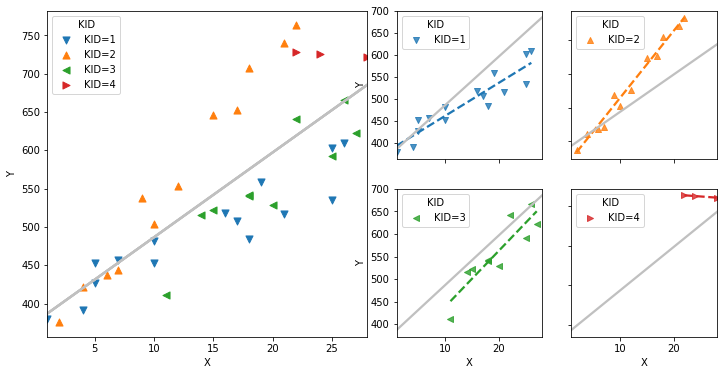

In [3]:
# overview plotting
from matplotlib.figure import figaspect
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.markers import MarkerStyle

# pre-define kwgs for sns.regplot() with whole data (not divided by KIDs)
regkwgs = {
    'x': 'X',
    'y': 'Y',
    'data': salary2,
    'scatter': False,
    'ci': None,
    'color': 'silver',
}

# visualize it
fig = plt.figure(figsize=(12, 6))
gs_master = GridSpec(nrows=2, ncols=4)
gs1 = GridSpecFromSubplotSpec(nrows=2, ncols=2, subplot_spec=gs_master[:, 0:2])
ax1 = fig.add_subplot(gs1[:, :])
for kid in salary2.KID.unique():
    ax1.scatter('X', 'Y', data=salary2.query('KID==@kid'), s=50, label='KID={}'.format(kid), marker=MarkerStyle.filled_markers[kid])
    sns.regplot(ax=ax1, **regkwgs)
    ax1.legend(title='KID')

gs2_5 = GridSpecFromSubplotSpec(nrows=2, ncols=2, subplot_spec=gs_master[:, 2:])
for row, col in np.ndindex(2, 2):
    ax = fig.add_subplot(gs2_5[row, col])
    kid = row*2 + col + 1
    sns.regplot('X', 'Y', data=salary2.query('KID==@kid'), ci=None, label='KID={}'.format(kid),
                ax=ax, color=sns.color_palette()[kid-1], marker=MarkerStyle.filled_markers[kid], line_kws={'linestyle': 'dashed'})
    sns.regplot(ax=ax, **regkwgs)
    ax.legend(title='KID')
    plt.setp(ax, xlabel='X' if row == 1 else '', ylabel='Y' if col == 0 else '')
    if row == 0:
        plt.setp(ax.get_xticklabels(), visible=False)
    if col == 1:
        plt.setp(ax.get_yticklabels(), visible=False)

plt.show();

In [0]:
# KID 4 has less samples than others and seems like non incremental liner relation.

## Wihtout considering groups' diff
$$
\begin{eqnarray}
    Y[n]&〜&y_{base}[n]+\epsilon[n]\\
    y_{base}[n]&〜&a+bX[n]\\
    \epsilon[n]&〜&Normal(0, \sigma_{Y})\\
\end{eqnarray}
$$
which means...

$$\begin{eqnarray}Y[n]&〜&Normal(a+bX[n], \sigma_{Y})\end{eqnarray}$$

In [16]:
from google.colab import files
files.upload()

Saving model8-3.stan to model8-3 (1).stan


{'model8-3.stan': b'data {\n  int N;\n  int K;\n  real X[N];\n  real Y[N];\n  int<lower=1, upper=K> KID[N];\n}\n\nparameters {\n  real a0;\n  real b0;\n  real ak[K];\n  real bk[K];\n  real<lower=0> s_a;\n  real<lower=0> s_b;\n  real<lower=0> s_Y;\n}\n\ntransformed parameters {\n  real a[K];\n  real b[K];\n  for (k in 1:K) {\n    a[k] = a0 + ak[k];\n    b[k] = b0 + bk[k];\n  }\n}\n\nmodel {\n  for (k in 1:K) {\n    ak[k] ~ normal(0, s_a);\n    bk[k] ~ normal(0, s_b);\n  }\n\n  for (n in 1:N)\n    Y[n] ~ normal(a[KID[n]] + b[KID[n]]*X[n], s_Y);\n}\n'}

In [0]:
StanData_NoGroups = {
    'N': salary2.shape[0],
    'X': salary2.X.values,
    'Y': salary2.Y.values
}

In [7]:
sm = pystan.StanModel(file='model8-1.stan')
fit = sm.sampling(data=StanData_NoGroups, iter=3000, chains=4, thin=1, n_jobs=-1)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dccd3b0f8586a498ed9ee063b5a2b8c8 NOW.


Inference for Stan model: anon_model_dccd3b0f8586a498ed9ee063b5a2b8c8.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a    375.57    0.52  24.44 328.15 359.36 375.48 391.89 423.52   2178    1.0
b     11.07    0.03   1.41   8.29  10.11   11.1  12.04  13.83   2128    1.0
s_Y    68.5    0.15    8.1  54.89  62.67  67.78  73.59  86.28   3023    1.0
lp__ -184.0    0.03   1.23 -187.3 -184.6 -183.7 -183.1 -182.6   2360    1.0

Samples were drawn using NUTS at Wed Apr 22 12:22:04 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

## With Considering groups' diffs
(just like considering 4 models depending on KID values; not coherent in whole companies)

In [0]:
StanData_WithGroups = {
    'N': salary2.shape[0],
    'K': salary2.KID.max(),
    'X': salary2.X.values,
    'KID': salary2.KID.values,
    'Y': salary2.Y.values
}

In [0]:
sm = pystan.StanModel(file='model8-2.stan')
fit = sm.sampling(data=StanData_WithGroups, iter=3000, chains=4, thin=1, n_jobs=-1)
fit

Inference for Stan model: anon_model_bed5448363bf2353924d7a4b5270f9c5.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[1] 386.98    0.23  14.17 358.61 377.52 386.91 396.47 414.63   3907    1.0
a[2] 329.05    0.25  16.63 296.11 318.07 328.73 339.97 362.03   4590    1.0
a[3]  313.7    0.58  34.06 243.75 291.92 314.23 336.36 379.88   3475    1.0
a[4] 745.42    2.49 153.23 441.68 644.83  745.9  846.8 1047.1   3777    1.0
b[1]   7.53    0.01   0.88    5.8   6.96   7.52   8.12   9.28   3791    1.0
b[2]  19.84    0.02   1.23  17.47  19.01  19.83  20.66  22.25   4593    1.0
b[3]  12.46    0.03   1.68    9.2  11.36  12.44  13.58  15.82   3396    1.0
b[4]  -0.82     0.1   6.19 -12.94  -4.93  -0.86   3.23  11.49   3776    1.0
s_Y   27.22    0.05   3.49  21.47  24.72   26.9  29.35  34.95   4648    1.0
lp__ -148.0    0.05   2.31 -153.2 -149.3 -147.6 -14

## Hierarchical Model
$$
\begin{eqnarray}
    Y[n]&〜& Normal(a[KID[n]]+b[KID[n]]X[n], \sigma_Y)\\
    a[k]&=&a_{global}+r_a[k]\\
    r_a[k]&〜&Normal(0, \sigma_a)\\
    b[k]&=&b_{global}+r_b[k]\\
    r_b[k]&〜&Normal(0, \sigma_b)
\end{eqnarray}
$$

this obviously means...

$$
\begin{eqnarray}
    Y[n]&〜&Normal(a[KID[n]]+b[KID[n]]X[n], \sigma_Y)\\
    a[k]&〜&Normal(a_{global}, \sigma_a)\\
    b[k]&〜&Normal(b_{global}, \sigma_b)
\end{eqnarray}
$$

In [0]:
StanData_Hierarchical = {
    'N': salary2.shape[0],
    'K': salary2.KID.max(),
    'X': salary2.X.values,
    'KID': salary2.KID.values,
    'Y': salary2.Y.values
}

In [18]:
sm = pystan.StanModel(file='model8-3 (1).stan')
fit = sm.sampling(data=StanData_Hierarchical)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4e36ce9cb09fd203b4489d9c77bc1c4d NOW.


Inference for Stan model: anon_model_4e36ce9cb09fd203b4489d9c77bc1c4d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0     391.7    7.12 147.33 165.54 335.75 369.13 419.56 753.93    429    1.0
b0      11.8    0.51    9.5  -6.79    9.1  12.34  15.33  27.32    350   1.01
ak[1]  -8.35    7.05  146.7 -362.5 -37.71   9.95   46.7 223.04    433    1.0
ak[2] -56.86    7.19 148.75 -420.1  -88.1 -32.15   1.76  167.6    428    1.0
ak[3] -66.97    7.33 151.55 -441.3 -103.1 -39.87  -0.78 161.89    427    1.0
ak[4] 100.22    6.62 167.73 -135.5   6.55  66.59 170.02  504.5    642    1.0
bk[1]  -4.07    0.51   9.49 -19.71  -7.53   -4.5  -1.36  14.09    351   1.01
bk[2]   7.62    0.51   9.58  -7.81    3.9   6.99  10.47  26.15    351   1.01
bk[3]   0.14    0.51   9.58 -15.44  -3.58  -0.56   3.04  19.37    354   1.01
bk[4]  -2.44    0.52  10.18 -22.35  -6.33